# <font color="red">Icon Prediction with Naive Bayes GaussianNB Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

DateTime  Year  Month  Day  Hour DaySegments  \
0 2023-01-01 00:00:00  2023      1    1     0  Late Night   
1 2023-01-01 01:00:00  2023      1    1     1  Late Night   
2 2023-01-01 02:00:00  2023      1    1     2  Late Night   
3 2023-01-01 03:00:00  2023      1    1     3  Late Night   
4 2023-01-01 04:00:00  2023      1    1     4  Late Night   

   DaySegments_Afternoon  DaySegments_Early Morning  DaySegments_Evening  \
0                      0                          0                    0   
1                      0                          0                    0   
2                      0                          0                    0   
3                      0                          0                    0   
4                      0                          0                    0   

   DaySegments_Late Night  ...  WindDir  SeaLevelPressure  CloudCover  \
0                       1  ...     0.49           1018.68        0.03   
1                       1  ...     0.54           1018.03        0.11   
2                       1  ...    30.51           1017.56        0.03   
3                       1  ...    49.23           1018.05        0.00   
4                       1  ...    49.90           1018.00       86.17   

   UVIndex  SevereRisk  Visibility  SolarRadiation SolarEnergy  \
0      0.0        10.0        2.76             0.0         0.0   
1      0.0        10.0        1.75             0.0         0.0   
2      0.0        10.0        1.75             0.0         0.0   
3      0.0        10.0        2.28             0.0         0.0   
4      0.0        10.0        1.27             0.0         0.0   

         Conditions         Icon  
0             Clear  clear-night  
1             Clear  clear-night  
2             Clear  clear-night  
3             Clear  clear-night  
4  Partially cloudy          fog  

[5 rows x 36 columns]

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

DateTime          Year         Month           Day  \
count                14616  14616.000000  14616.000000  14616.000000   
mean   2023-11-01 11:30:00   2023.400657      5.720854     15.735632   
min    2023-01-01 00:00:00   2023.000000      1.000000      1.000000   
25%    2023-06-02 05:45:00   2023.000000      3.000000      8.000000   
50%    2023-11-01 11:30:00   2023.000000      6.000000     16.000000   
75%    2024-04-01 17:15:00   2024.000000      8.000000     23.000000   
max    2024-08-31 23:00:00   2024.000000     12.000000     31.000000   
std                    NaN      0.490048      3.195073      8.803610   

               Hour  DaySegments_Afternoon  DaySegments_Early Morning  \
count  14616.000000           14616.000000               14616.000000   
mean      11.500000               0.131294                   0.060550   
min        0.000000               0.000000                   0.000000   
25%        5.750000               0.000000                   0.000000   
50%       11.500000               0.000000                   0.000000   
75%       17.250000               0.000000                   0.000000   
max       23.000000               1.000000                   1.000000   
std        6.922423               0.337734                   0.238511   

       DaySegments_Evening  DaySegments_Late Night  DaySegments_Midday  ...  \
count         14616.000000            14616.000000        14616.000000  ...   
mean              0.098043                0.249726            0.116585  ...   
min               0.000000                0.000000            0.000000  ...   
25%               0.000000                0.000000            0.000000  ...   
50%               0.000000                0.000000            0.000000  ...   
75%               0.000000                0.000000            0.000000  ...   
max               1.000000                1.000000            1.000000  ...   
std               0.297383                0.432869            0.320936  ...   

           Windgust     WindSpeed       WindDir  SeaLevelPressure  \
count  14616.000000  14616.000000  14616.000000      14616.000000   
mean      17.068560      8.090783    159.739178       1008.265012   
min        0.660000      0.000000      0.000000        982.420000   
25%        9.170000      2.870000     80.965000       1003.277500   
50%       14.645000      7.670000    163.790000       1007.970000   
75%       23.410000     11.750000    241.402500       1013.400000   
max       84.120000     71.970000    360.000000       1022.060000   
std       10.195911      6.250203    104.422027          6.010683   

         CloudCover       UVIndex    SevereRisk    Visibility  SolarRadiation  \
count  14616.000000  14616.000000  14616.000000  14616.000000    14616.000000   
mean      53.579923      2.263555     16.504787      4.368134      227.640683   
min        0.000000      0.000000      3.000000      0.000000        0.000000   
25%       26.670000      0.000000     10.000000      3.990000        0.000000   
50%       51.540000      0.000000     10.000000      4.650000       10.665000   
75%       87.790000      4.740000     12.580000      4.650000      459.745000   
max      100.000000     10.000000     97.740000     24.100000     1026.650000   
std       35.166637      3.083074     15.031827      1.376994      307.219387   

        SolarEnergy  
count  14616.000000  
mean       0.819217  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        1.660000  
max        3.700000  
std        1.106444  

[8 rows x 32 columns]

# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Parameters

In [9]:
grid_param = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

In [10]:
number_of_model_for_randomized_grid = 100
model_name_for_saving = "Naive Bayes GaussianNB"
target_name_for_saving = "Icon"
number_of_model_for_bagging = 100

# All Features

In [11]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Icon']

In [12]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Icon']

In [13]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [14]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## MinMax Scaler

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [16]:
X_train

array([[0.45454545, 0.2       , 0.04347826, ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.8       , 0.82608696, ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.9       , 0.86956522, ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.66666667, 0.13043478, ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.33333333, 0.47826087, ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.1       , 0.39130435, ..., 0.9903    , 0.471     ,
        0.07388643]], shape=(11692, 27))

In [17]:
X_test

array([[0.81818182, 1.        , 0.04347826, ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.33333333, 0.13043478, ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.63333333, 0.65217391, ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13333333, 0.13043478, ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.4       , 0.60869565, ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.23333333, 0.47826087, ..., 1.        , 0.119     ,
        0.07388643]], shape=(2923, 27))

### Default Parameters

In [18]:
training_model = GaussianNB()
training_model

GaussianNB()

In [19]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 18.1 ms


GaussianNB()

In [20]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8330
Precision: 0.9082
Recall:    0.8330
F1-Score:  0.8576


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.86      0.90       301
        clear-night       0.95      0.62      0.75       362
             cloudy       0.40      0.02      0.03       125
                fog       0.01      1.00      0.03         4
  partly-cloudy-day       0.89      0.89      0.89       774
partly-cloudy-night       0.91      0.87      0.89       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.83      2923
          macro avg       0.73      0.75      0.64      2923
       weighted avg       0.91      0.83      0.86      2923



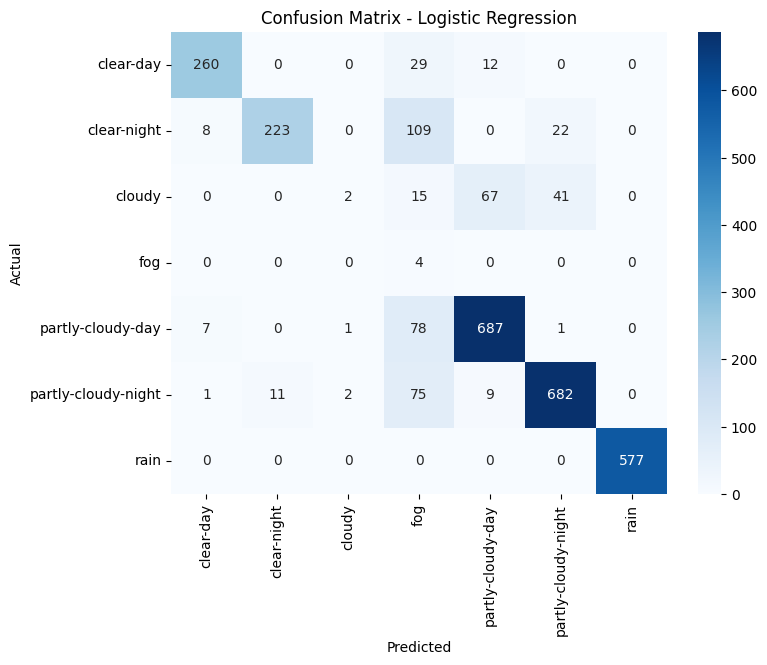

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9909
clear-night : 0.9816
cloudy   : 0.9389
fog      : 0.9656
partly-cloudy-day : 0.9667
partly-cloudy-night : 0.9738
rain     : 1.0000
Micro-avg : 0.9731


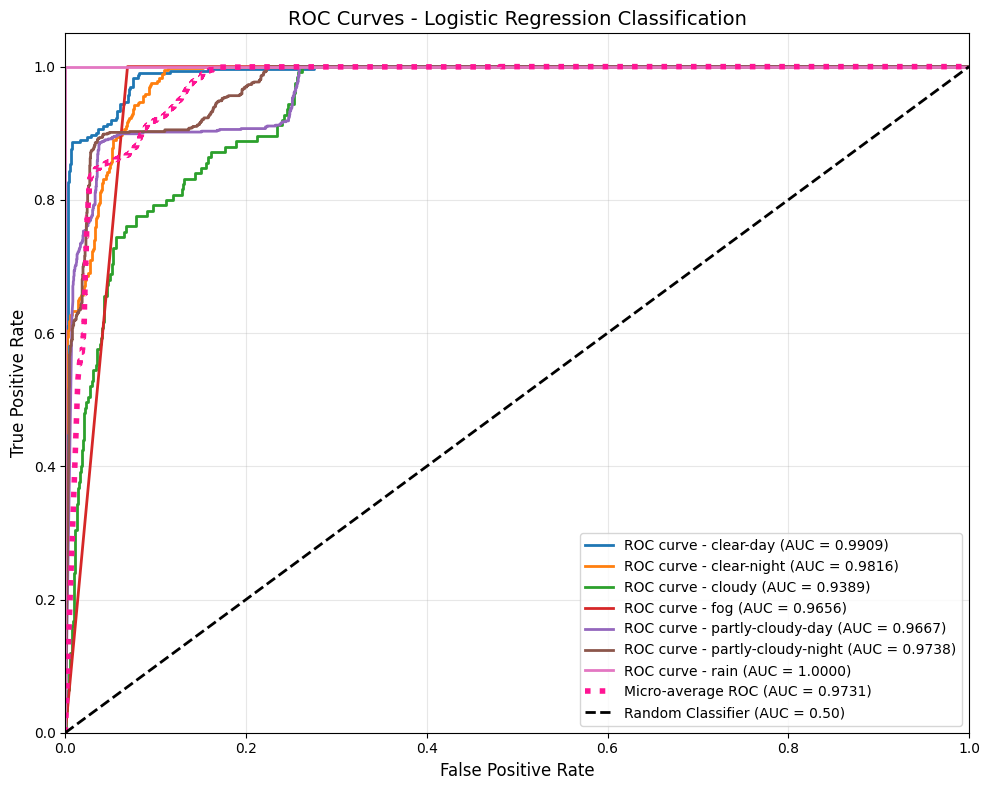

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9783
One-vs-One (Weighted)  : 0.9725
Micro-average          : 0.9731


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.833048, F1: 0.857632, AUC (micro-avg): 0.973124
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 234 ms
Wall time: 3.78 s


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 0.001}
Best Cross-Validation Score: 0.8904639884129392


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

In [36]:
y_pred_grid

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [37]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8779
Precision: 0.9264
Recall:    0.8779
F1-Score:  0.8864


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.90      0.92       301
        clear-night       0.99      0.78      0.87       362
             cloudy       0.78      0.06      0.10       125
                fog       0.02      1.00      0.05         4
  partly-cloudy-day       0.89      0.92      0.91       774
partly-cloudy-night       0.90      0.91      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.88      2923
          macro avg       0.79      0.80      0.68      2923
       weighted avg       0.93      0.88      0.89      2923



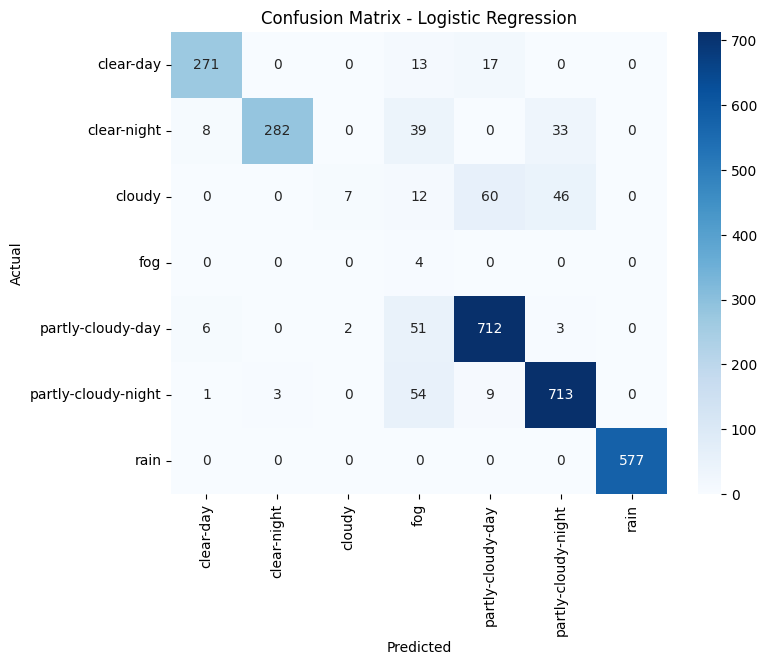

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9967
clear-night : 0.9957
cloudy   : 0.9438
fog      : 0.9947
partly-cloudy-day : 0.9806
partly-cloudy-night : 0.9807
rain     : 1.0000
Micro-avg : 0.9876


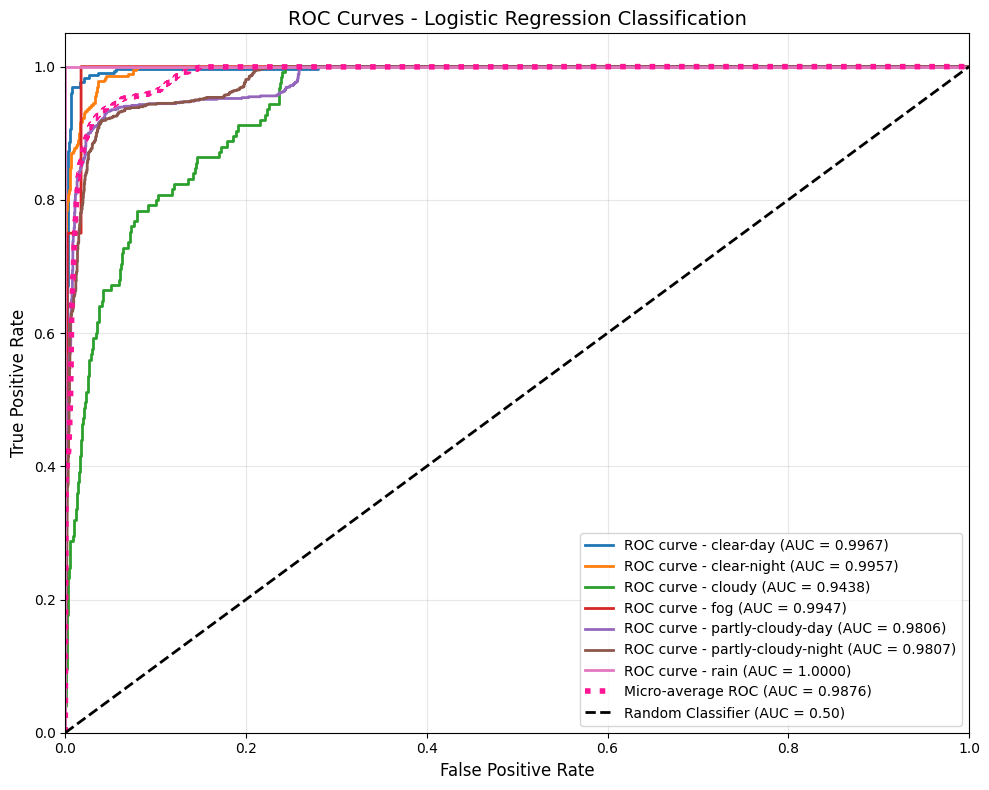

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9864
One-vs-One (Weighted)  : 0.9831
Micro-average          : 0.9876


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.877865, F1: 0.886441, AUC (micro-avg): 0.987625
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = GaussianNB()
base_model

GaussianNB()

In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 554 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8419
Precision: 0.9112
Recall:    0.8419
F1-Score:  0.8617


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.89      0.92       301
        clear-night       0.98      0.66      0.79       362
             cloudy       0.50      0.01      0.02       125
                fog       0.01      1.00      0.03         4
  partly-cloudy-day       0.87      0.90      0.88       774
partly-cloudy-night       0.91      0.86      0.89       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.84      2923
          macro avg       0.75      0.76      0.65      2923
       weighted avg       0.91      0.84      0.86      2923



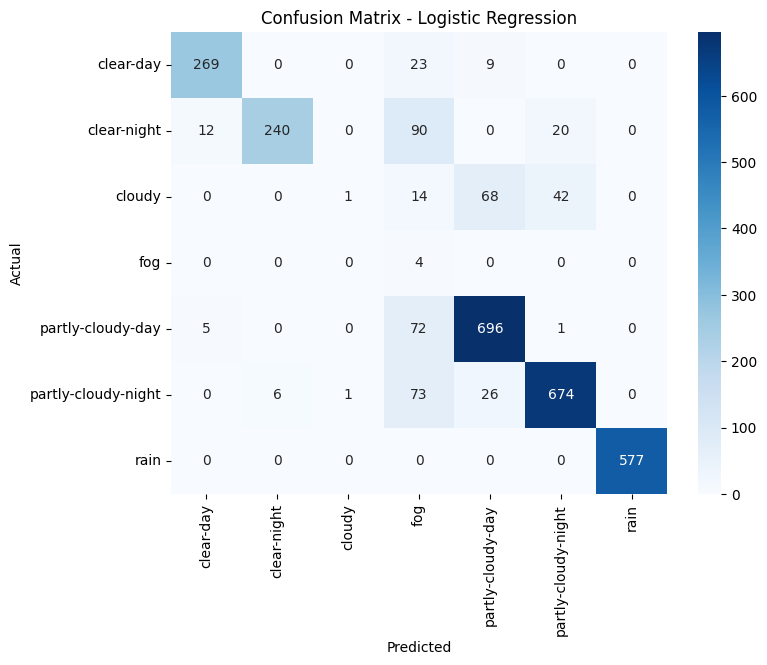

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9886
clear-night : 0.9833
cloudy   : 0.8842
fog      : 0.9892
partly-cloudy-day : 0.9504
partly-cloudy-night : 0.9672
rain     : 1.0000
Micro-avg : 0.9641


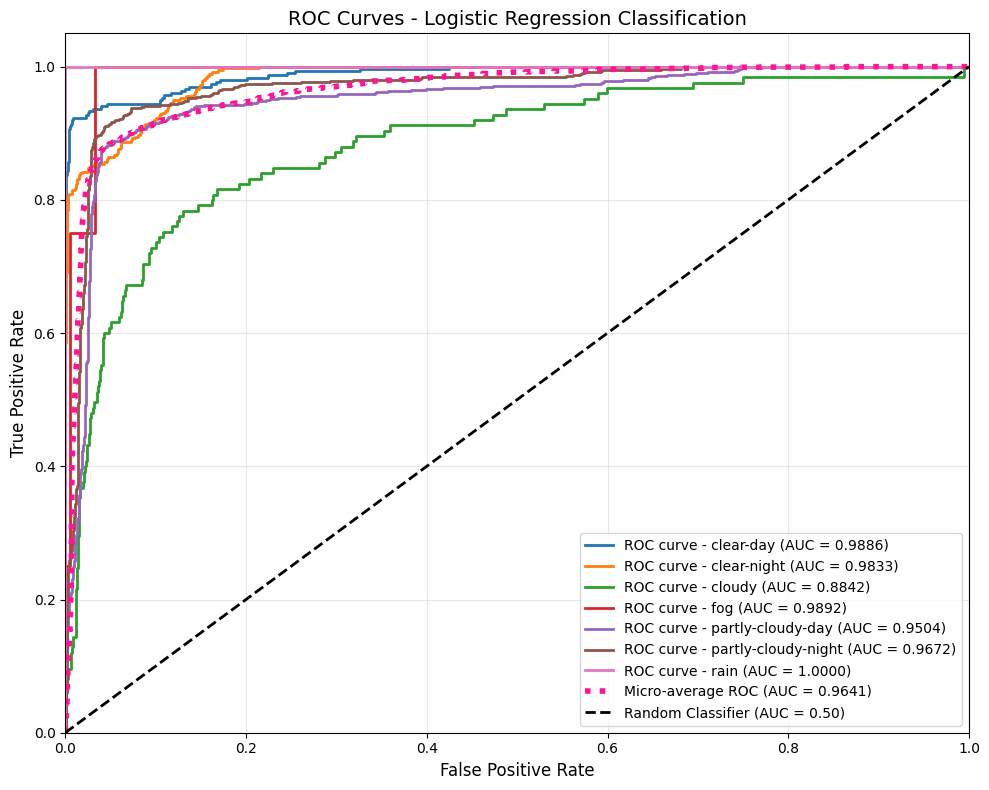

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9699
One-vs-One (Weighted)  : 0.9631
Micro-average          : 0.9641


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.841943, F1: 0.861714, AUC (micro-avg): 0.964055
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [63]:
X_train

array([[ 0.08873237, -0.9946814 , -1.51753864, ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.04440482,  1.07523376, ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.38425252,  1.21927667, ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591,  0.59127454, -1.22945281, ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.54155113, -0.07710953, ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -1.33452911, -0.36519535, ...,  1.29498106,
         0.80247092, -0.4299225 ]], shape=(11692, 27))

In [64]:
X_test

array([[ 1.33830651,  1.72410022, -1.51753864, ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -0.54155113, -1.22945281, ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.47799198,  0.49906212, ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22124654, -1.22945281, ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004, -0.314986  ,  0.35501921, ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.88139884, -0.07710953, ...,  1.32256164,
        -0.34325307, -0.4299225 ]], shape=(2923, 27))

### Default Parameters

In [65]:
training_model = GaussianNB()
training_model

GaussianNB()

In [66]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 15.4 ms


GaussianNB()

In [67]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [68]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8293
Precision: 0.9079
Recall:    0.8293
F1-Score:  0.8555


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.85      0.89       301
        clear-night       0.94      0.61      0.74       362
             cloudy       0.40      0.02      0.03       125
                fog       0.01      1.00      0.02         4
  partly-cloudy-day       0.89      0.88      0.88       774
partly-cloudy-night       0.92      0.87      0.89       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.83      2923
          macro avg       0.73      0.75      0.64      2923
       weighted avg       0.91      0.83      0.86      2923



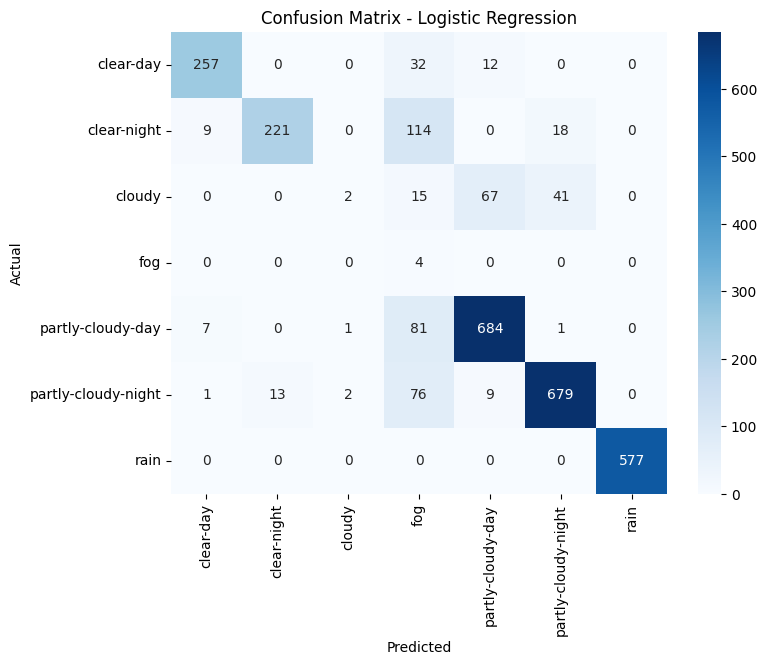

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9903
clear-night : 0.9790
cloudy   : 0.9374
fog      : 0.9625
partly-cloudy-day : 0.9661
partly-cloudy-night : 0.9731
rain     : 1.0000
Micro-avg : 0.9717


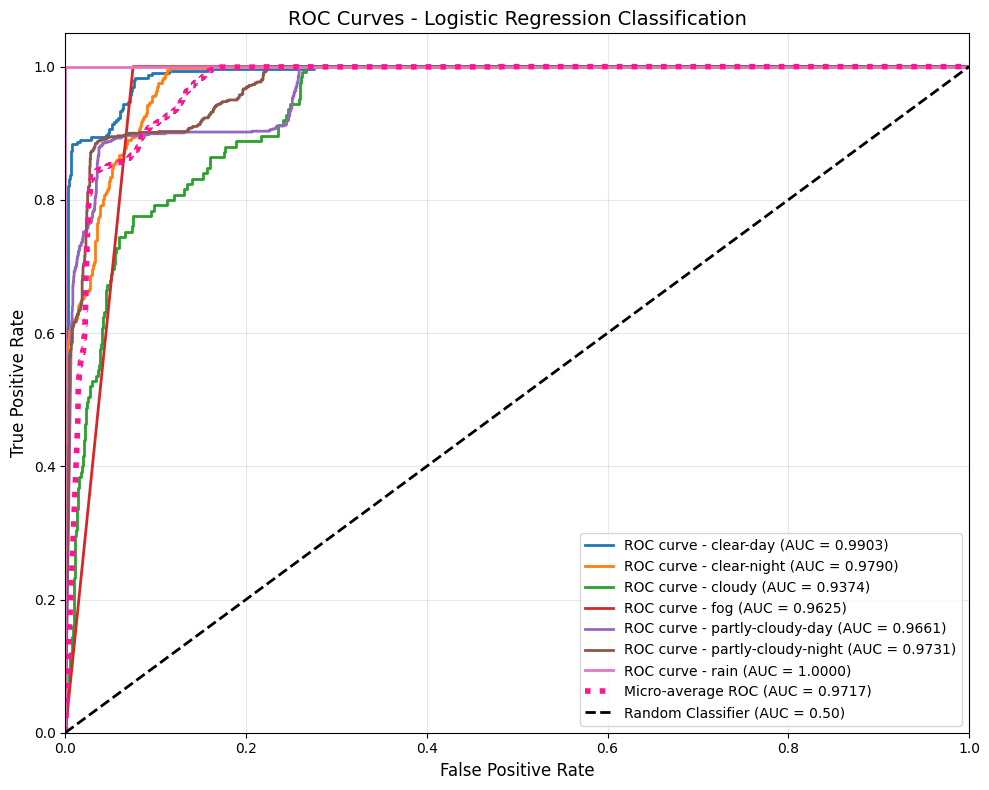

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9775
One-vs-One (Weighted)  : 0.9715
Micro-average          : 0.9717


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.829285, F1: 0.855521, AUC (micro-avg): 0.971706
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 93.8 ms
Wall time: 888 ms


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 0.001}
Best Cross-Validation Score: 0.8902268670871603


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8785
Precision: 0.9303
Recall:    0.8785
F1-Score:  0.8867


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.90      0.92       301
        clear-night       0.99      0.78      0.87       362
             cloudy       0.88      0.06      0.11       125
                fog       0.02      1.00      0.05         4
  partly-cloudy-day       0.89      0.92      0.91       774
partly-cloudy-night       0.90      0.92      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.88      2923
          macro avg       0.80      0.80      0.68      2923
       weighted avg       0.93      0.88      0.89      2923



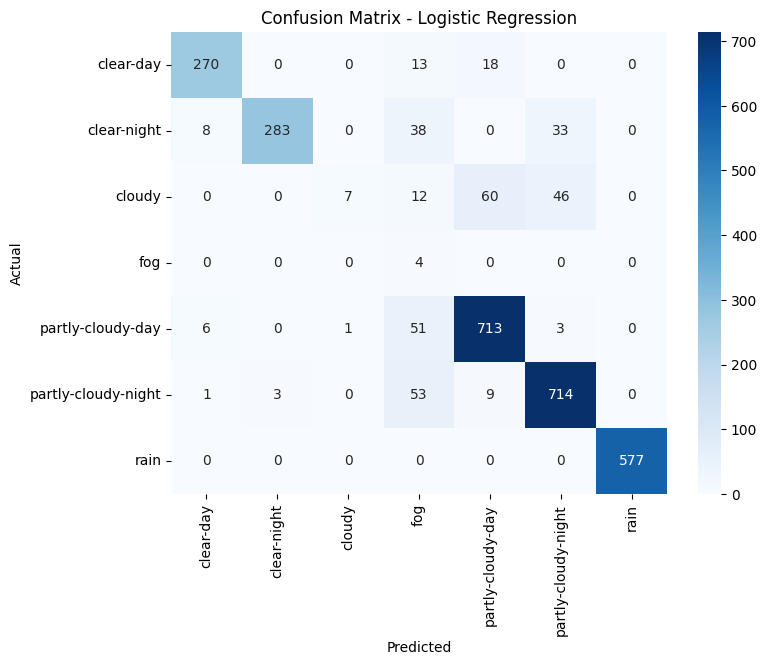

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9967
clear-night : 0.9958
cloudy   : 0.9450
fog      : 0.9950
partly-cloudy-day : 0.9808
partly-cloudy-night : 0.9810
rain     : 1.0000
Micro-avg : 0.9877


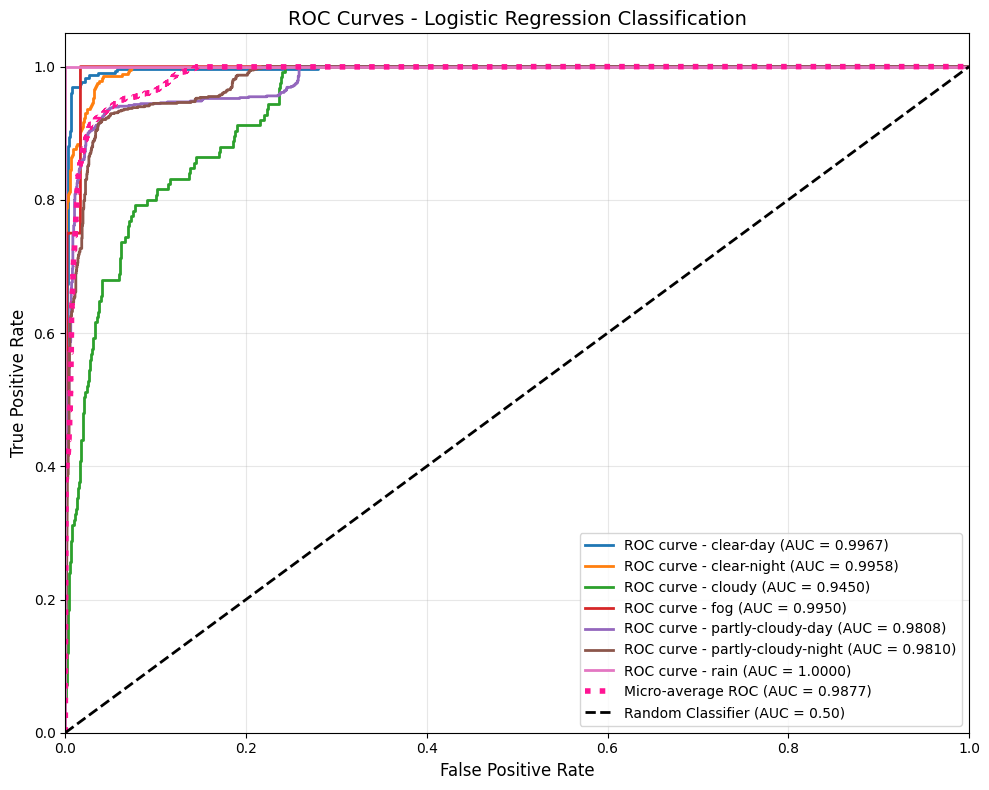

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9866
One-vs-One (Weighted)  : 0.9833
Micro-average          : 0.9877


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.878549, F1: 0.886718, AUC (micro-avg): 0.987713
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = GaussianNB()
base_model

GaussianNB()

In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 46.9 ms
Wall time: 460 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8354
Precision: 0.9102
Recall:    0.8354
F1-Score:  0.8573


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.89      0.91       301
        clear-night       0.97      0.64      0.77       362
             cloudy       0.50      0.01      0.02       125
                fog       0.01      1.00      0.03         4
  partly-cloudy-day       0.87      0.90      0.88       774
partly-cloudy-night       0.91      0.85      0.88       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.84      2923
          macro avg       0.74      0.76      0.64      2923
       weighted avg       0.91      0.84      0.86      2923



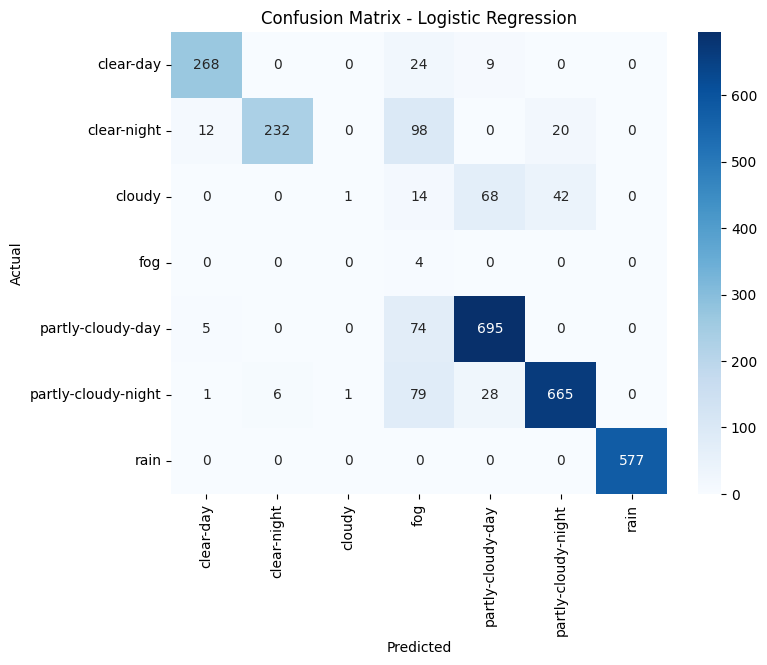

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9878
clear-night : 0.9816
cloudy   : 0.8827
fog      : 0.9890
partly-cloudy-day : 0.9482
partly-cloudy-night : 0.9667
rain     : 1.0000
Micro-avg : 0.9626


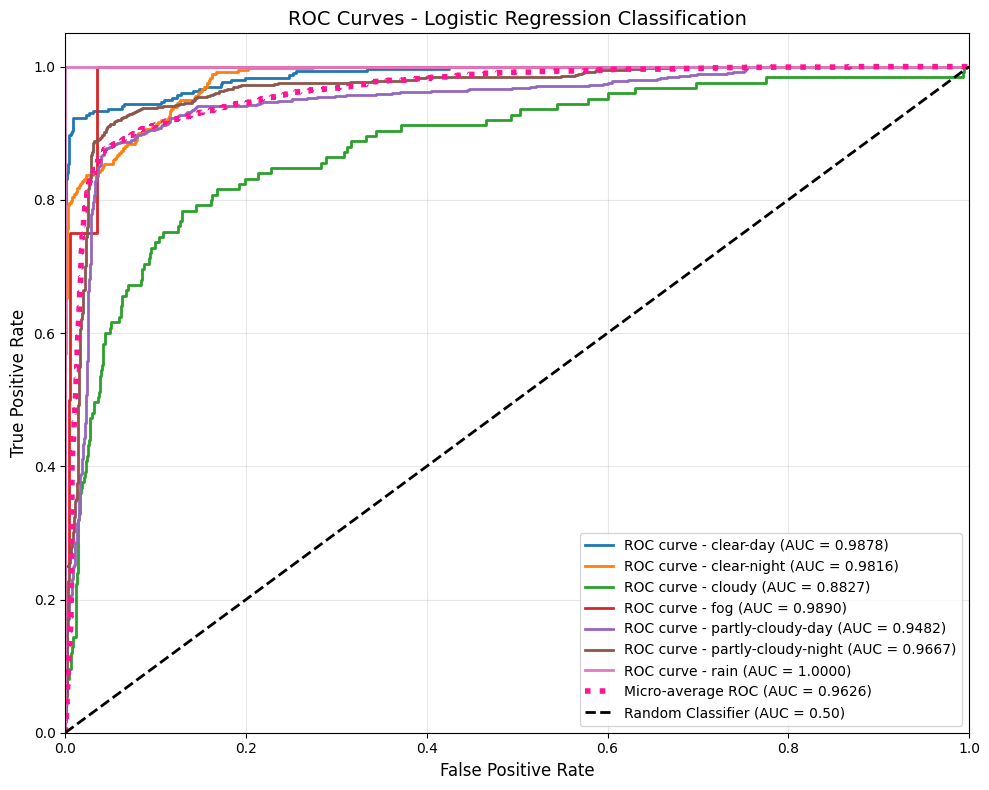

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9688
One-vs-One (Weighted)  : 0.9621
Micro-average          : 0.9626


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.835443, F1: 0.857263, AUC (micro-avg): 0.962604
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [108]:
X_train

array([[ 0.00000000e+00, -6.00000000e-01, -9.16666667e-01, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  6.00000000e-01,  5.83333333e-01, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  8.00000000e-01,  6.66666667e-01, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01,  3.33333333e-01, -7.50000000e-01, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.33333333e-01, -8.33333333e-02, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -8.00000000e-01, -2.50000000e-01, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]],
      shape=(11692, 27))

In [109]:
X_test

array([[ 0.8       ,  1.        , -0.91666667, ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.33333333, -0.75      , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.26666667,  0.25      , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.73333333, -0.75      , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        , -0.2       ,  0.16666667, ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.53333333, -0.08333333, ...,  0.79384817,
         0.25757576,  0.        ]], shape=(2923, 27))

### Default Parameters

In [110]:
training_model = GaussianNB()
training_model

GaussianNB()

In [111]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 16 ms


GaussianNB()

In [112]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [113]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8563
Precision: 0.9186
Recall:    0.8563
F1-Score:  0.8753


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.89      0.92       301
        clear-night       0.97      0.70      0.82       362
             cloudy       0.57      0.06      0.12       125
                fog       0.02      1.00      0.03         4
  partly-cloudy-day       0.89      0.90      0.90       774
partly-cloudy-night       0.91      0.89      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.86      2923
          macro avg       0.76      0.78      0.67      2923
       weighted avg       0.92      0.86      0.88      2923



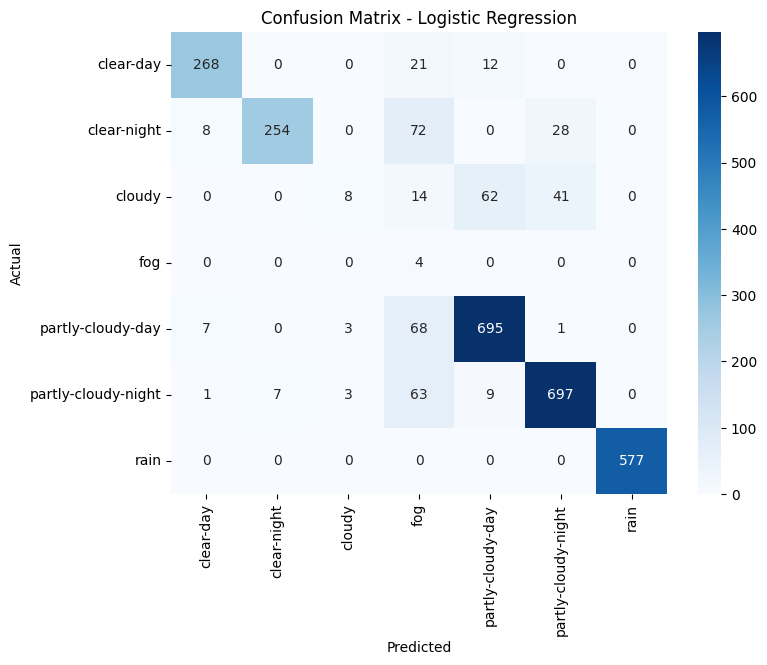

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9937
clear-night : 0.9913
cloudy   : 0.9425
fog      : 0.9844
partly-cloudy-day : 0.9738
partly-cloudy-night : 0.9767
rain     : 1.0000
Micro-avg : 0.9806


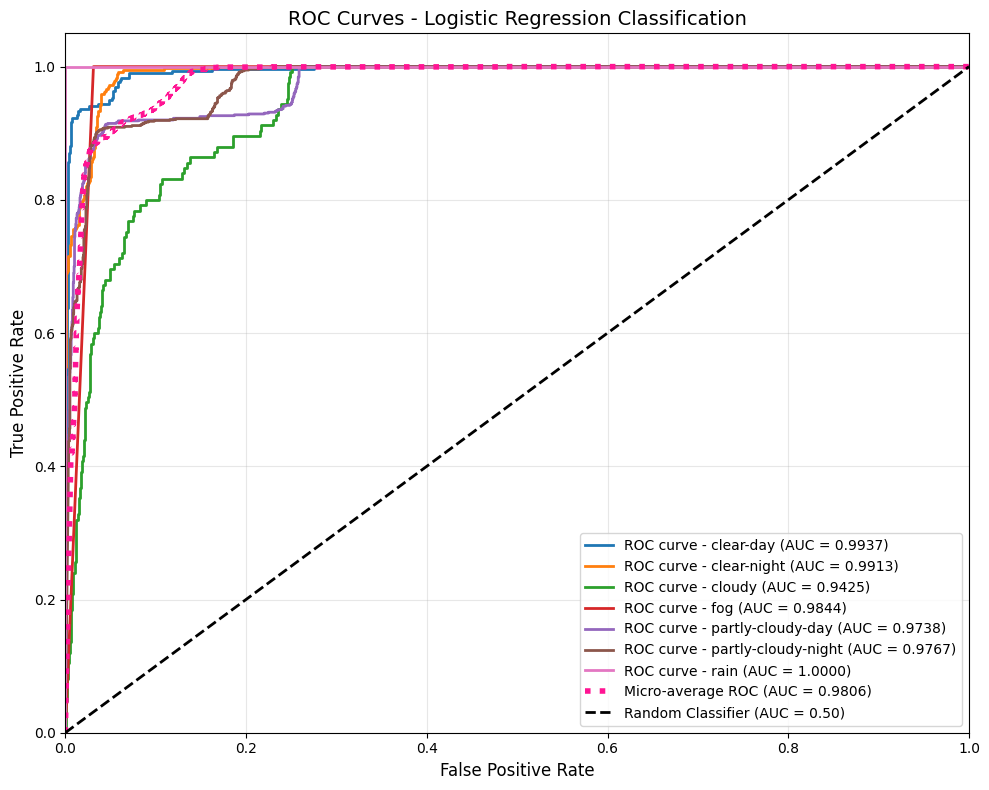

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9826
One-vs-One (Weighted)  : 0.9787
Micro-average          : 0.9806


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.856312, F1: 0.875317, AUC (micro-avg): 0.980596
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 141 ms
Wall time: 889 ms


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 1e-07}
Best Cross-Validation Score: 0.8891961426433352


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8724
Precision: 0.9154
Recall:    0.8724
F1-Score:  0.8879


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.92      0.93       301
        clear-night       0.96      0.78      0.86       362
             cloudy       0.50      0.14      0.22       125
                fog       0.02      1.00      0.04         4
  partly-cloudy-day       0.91      0.90      0.90       774
partly-cloudy-night       0.90      0.89      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.87      2923
          macro avg       0.75      0.80      0.69      2923
       weighted avg       0.92      0.87      0.89      2923



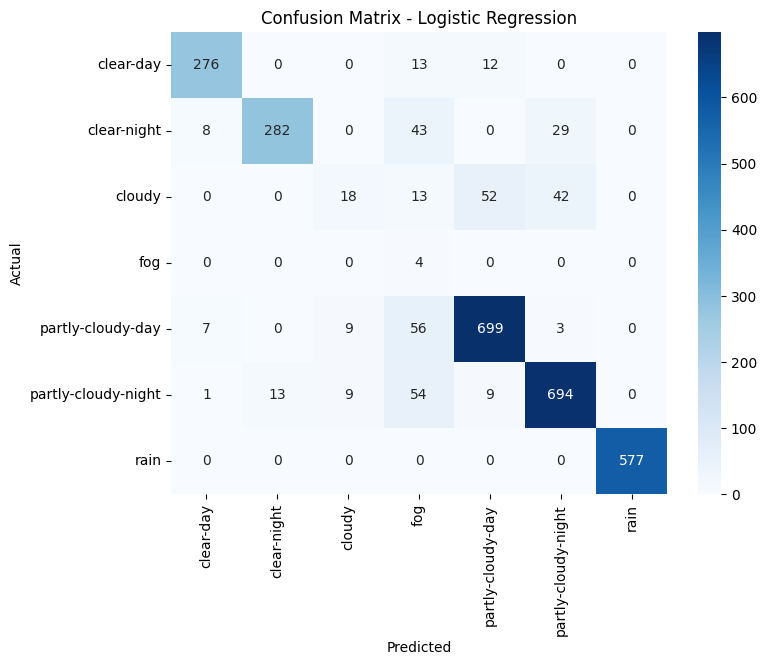

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9951
clear-night : 0.9935
cloudy   : 0.9397
fog      : 0.9928
partly-cloudy-day : 0.9782
partly-cloudy-night : 0.9798
rain     : 1.0000
Micro-avg : 0.9862


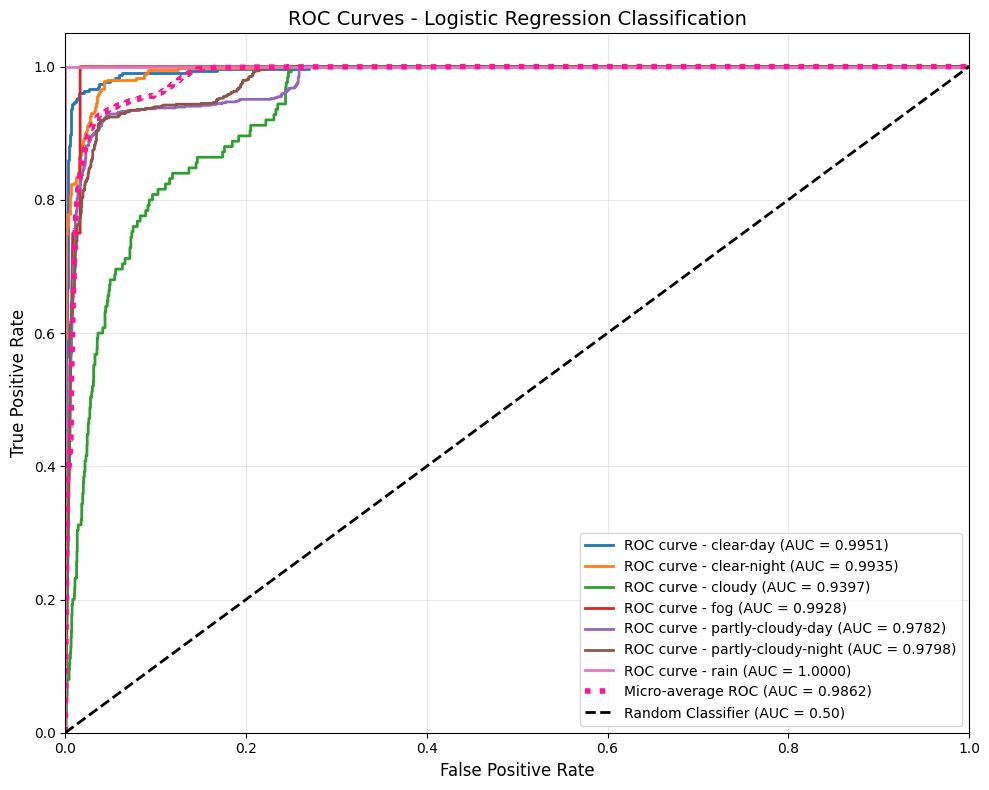

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9850
One-vs-One (Weighted)  : 0.9815
Micro-average          : 0.9862


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.872391, F1: 0.887907, AUC (micro-avg): 0.986155
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = GaussianNB()
base_model

GaussianNB()

In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 62.5 ms
Wall time: 418 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8676
Precision: 0.9267
Recall:    0.8676
F1-Score:  0.8829


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.96      0.92      0.94       301
        clear-night       0.99      0.74      0.85       362
             cloudy       0.67      0.05      0.09       125
                fog       0.02      1.00      0.04         4
  partly-cloudy-day       0.89      0.91      0.90       774
partly-cloudy-night       0.91      0.90      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.87      2923
          macro avg       0.78      0.79      0.67      2923
       weighted avg       0.93      0.87      0.88      2923



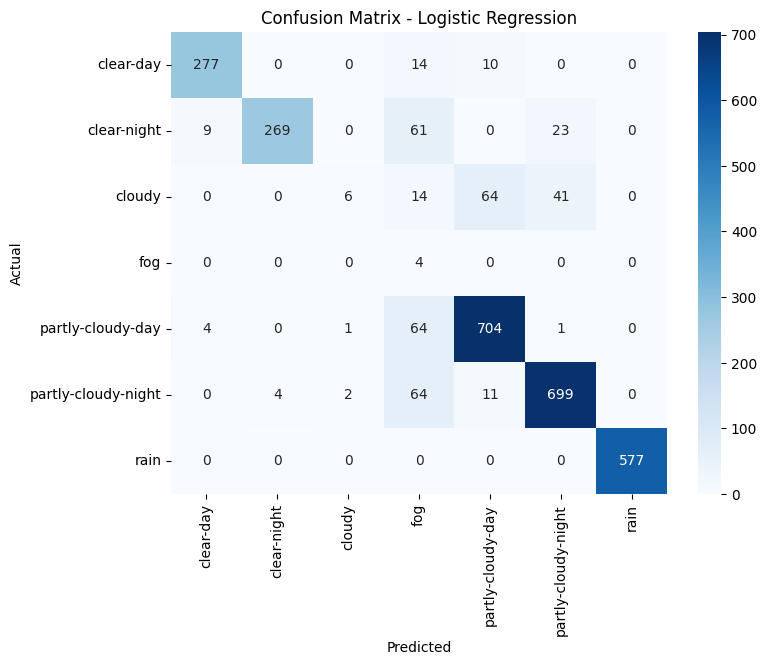

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9892
clear-night : 0.9857
cloudy   : 0.9041
fog      : 0.9909
partly-cloudy-day : 0.9589
partly-cloudy-night : 0.9690
rain     : 1.0000
Micro-avg : 0.9708


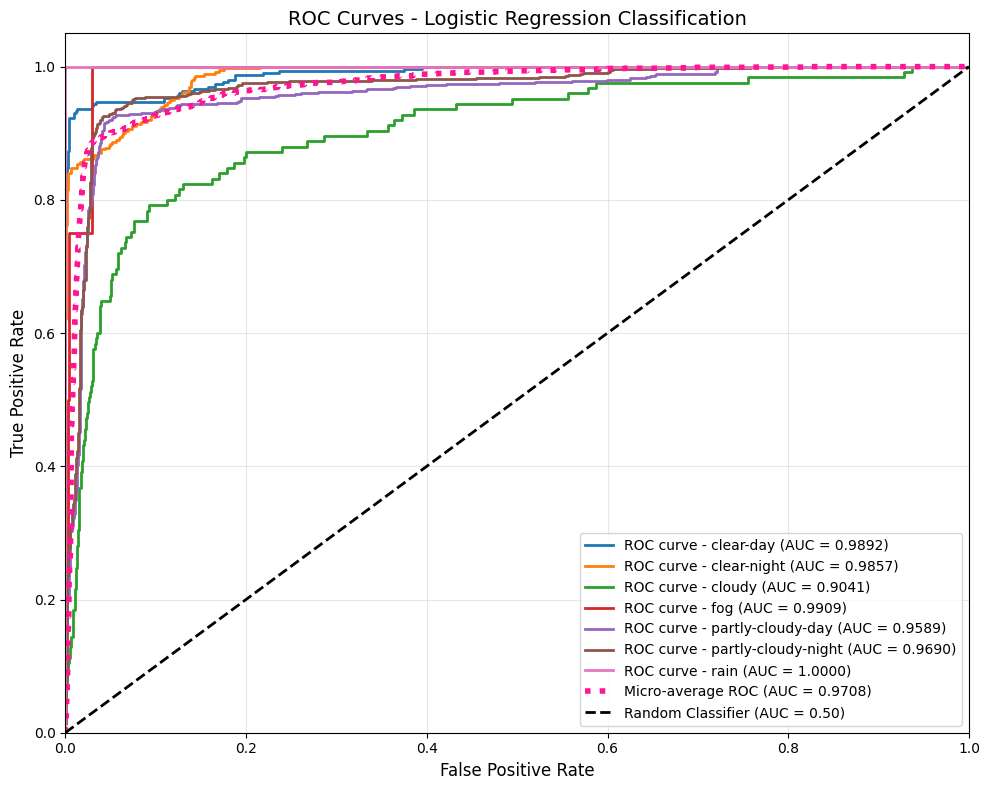

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9738
One-vs-One (Weighted)  : 0.9682
Micro-average          : 0.9708


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.867602, F1: 0.882888, AUC (micro-avg): 0.970771
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [158]:
X_train

array([[0.45454545, 0.04347826, 0.        , ..., 0.4839    , 0.        ,
        0.27580747],
       [0.45454545, 0.82608696, 0.        , ..., 0.7139    , 0.        ,
        0.07388643],
       [0.63636364, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.10111885],
       ...,
       [0.54545455, 0.13043478, 0.        , ..., 0.894     , 0.        ,
        0.07388643],
       [0.45454545, 0.47826087, 0.        , ..., 0.8714    , 0.9       ,
        0.27812962],
       [0.54545455, 0.39130435, 0.        , ..., 0.9903    , 0.471     ,
        0.07388643]], shape=(11692, 23))

In [159]:
X_test

array([[0.81818182, 0.04347826, 0.        , ..., 0.0323    , 0.        ,
        0.07388643],
       [0.36363636, 0.13043478, 0.        , ..., 0.492     , 0.        ,
        0.06438674],
       [0.63636364, 0.65217391, 1.        , ..., 0.8467    , 0.49      ,
        0.25775807],
       ...,
       [0.63636364, 0.13043478, 0.        , ..., 0.5704    , 0.        ,
        0.07388643],
       [0.90909091, 0.60869565, 1.        , ..., 0.2903    , 0.7       ,
        0.07388643],
       [0.63636364, 0.47826087, 0.        , ..., 1.        , 0.119     ,
        0.07388643]], shape=(2923, 23))

#### Default Parameters

In [160]:
training_model = GaussianNB()
training_model

GaussianNB()

In [161]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 13.3 ms


GaussianNB()

In [162]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [163]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8317
Precision: 0.9147
Recall:    0.8317
F1-Score:  0.8589


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.86      0.90       301
        clear-night       0.95      0.63      0.76       362
             cloudy       0.50      0.02      0.05       125
                fog       0.01      1.00      0.02         4
  partly-cloudy-day       0.89      0.88      0.88       774
partly-cloudy-night       0.92      0.87      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.83      2923
          macro avg       0.74      0.75      0.64      2923
       weighted avg       0.91      0.83      0.86      2923



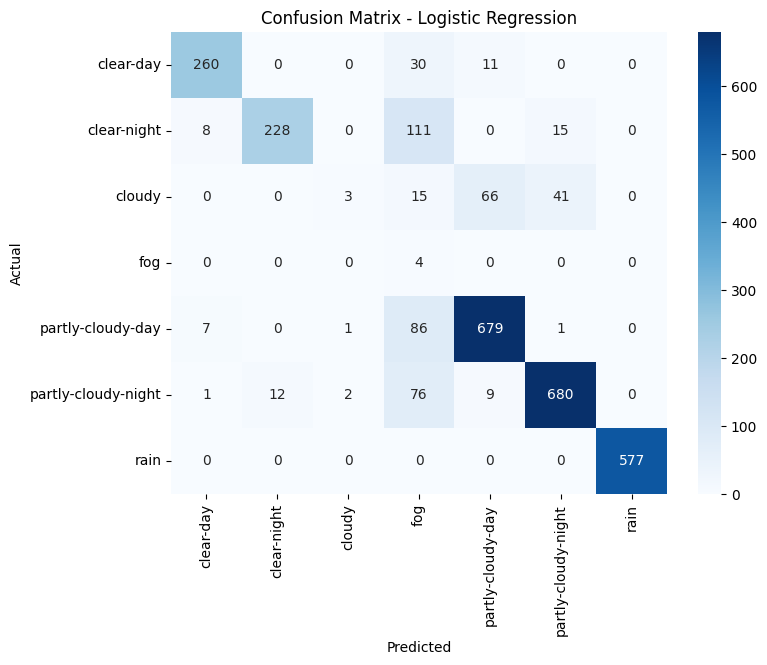

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9910
clear-night : 0.9814
cloudy   : 0.9416
fog      : 0.9639
partly-cloudy-day : 0.9653
partly-cloudy-night : 0.9748
rain     : 1.0000
Micro-avg : 0.9726


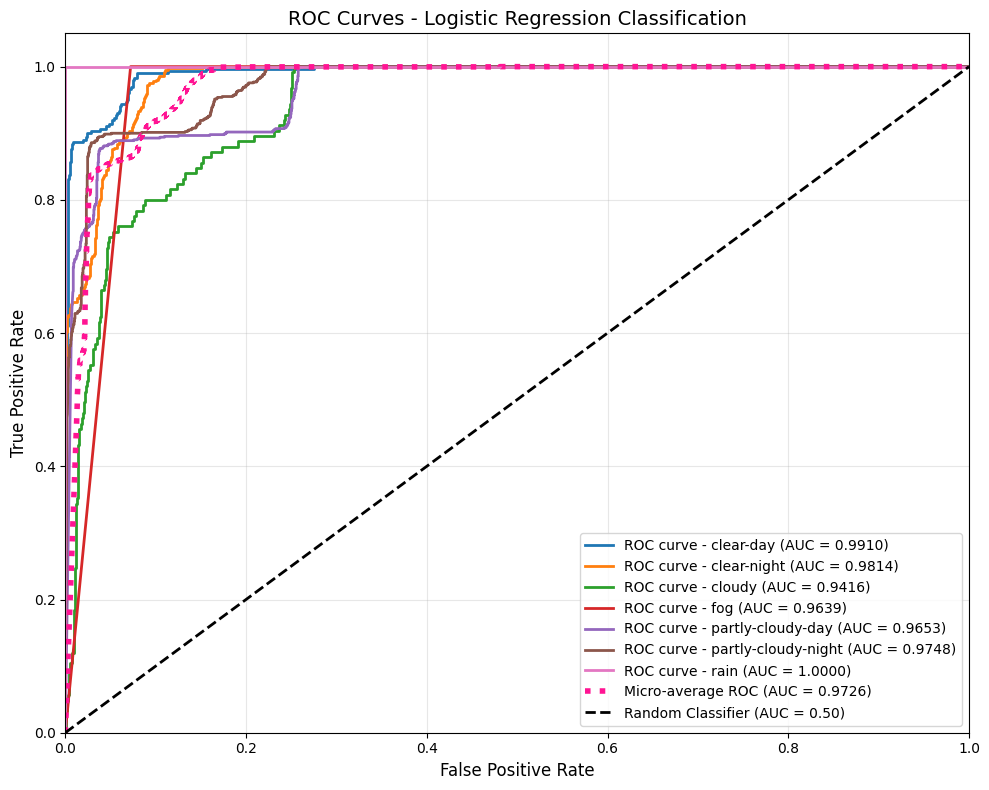

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9783
One-vs-One (Weighted)  : 0.9725
Micro-average          : 0.9726


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.833048 ≈ 0.831680 (similar)
   F1-Score: 0.857632 ≈ 0.858892 (similar)
   AUC (micro-avg): 0.973124 ≈ 0.972601
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 188 ms
Wall time: 837 ms


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 0.001}
Best Cross-Validation Score: 0.889902675565066


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8751
Precision: 0.9235
Recall:    0.8751
F1-Score:  0.8841


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.90      0.92       301
        clear-night       0.99      0.78      0.87       362
             cloudy       0.71      0.04      0.08       125
                fog       0.02      1.00      0.04         4
  partly-cloudy-day       0.89      0.92      0.90       774
partly-cloudy-night       0.90      0.91      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.88      2923
          macro avg       0.78      0.79      0.67      2923
       weighted avg       0.92      0.88      0.88      2923



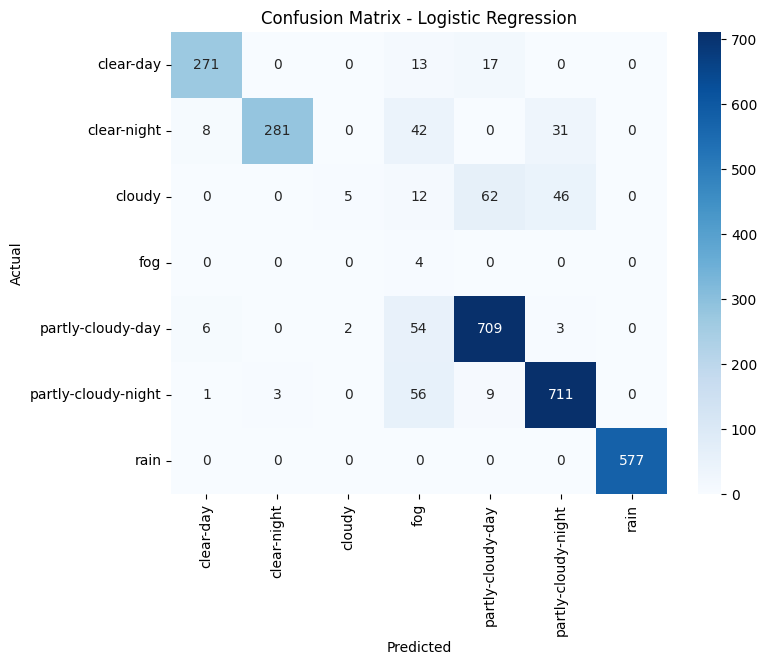

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9968
clear-night : 0.9962
cloudy   : 0.9459
fog      : 0.9928
partly-cloudy-day : 0.9801
partly-cloudy-night : 0.9816
rain     : 1.0000
Micro-avg : 0.9875


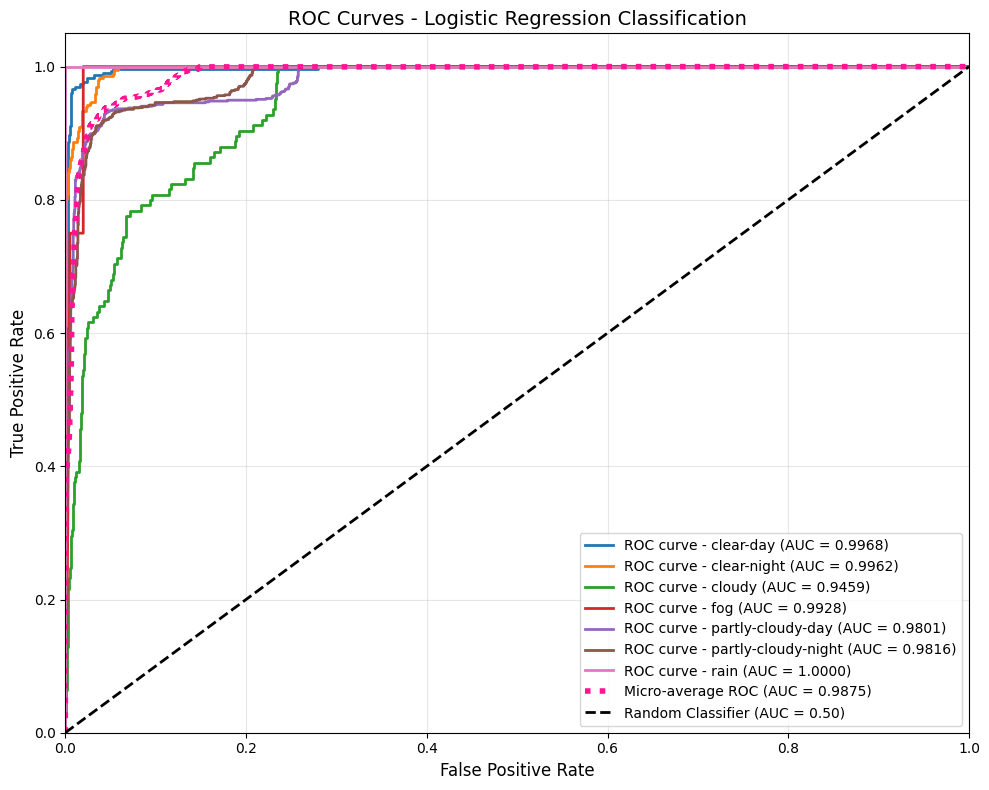

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9867
One-vs-One (Weighted)  : 0.9832
Micro-average          : 0.9875


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.877865 ≈ 0.875128 (similar)
   F1-Score: 0.886441 ≈ 0.884071 (similar)
   AUC (micro-avg): 0.987625 ≈ 0.987544
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = GaussianNB()
base_model

GaussianNB()

In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 371 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7910
Precision: 0.8721
Recall:    0.7910
F1-Score:  0.8180


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.77      0.89      0.83       301
        clear-night       0.76      0.64      0.69       362
             cloudy       0.50      0.02      0.03       125
                fog       0.01      1.00      0.02         4
  partly-cloudy-day       0.89      0.80      0.84       774
partly-cloudy-night       0.92      0.79      0.85       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.79      2923
          macro avg       0.69      0.73      0.61      2923
       weighted avg       0.87      0.79      0.82      2923



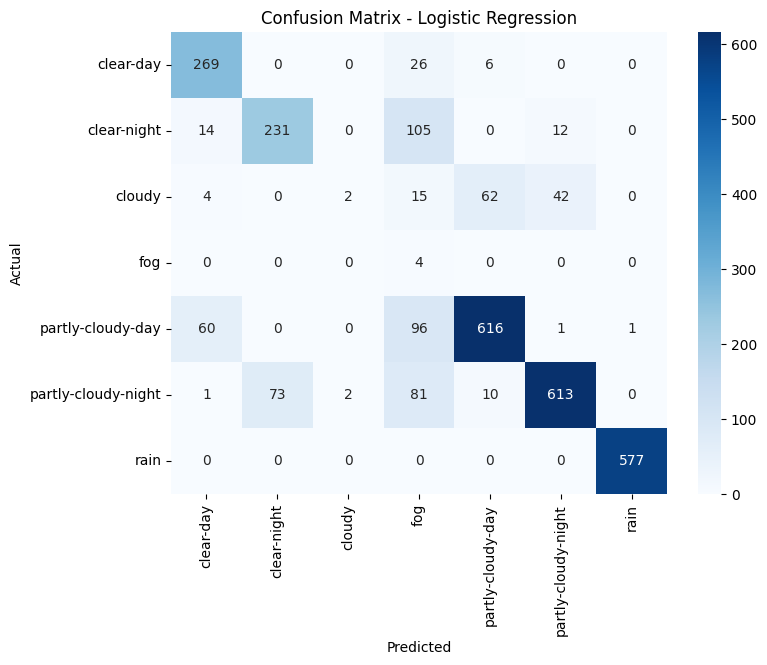

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9785
clear-night : 0.9538
cloudy   : 0.8654
fog      : 0.9841
partly-cloudy-day : 0.9359
partly-cloudy-night : 0.9639
rain     : 1.0000
Micro-avg : 0.9523


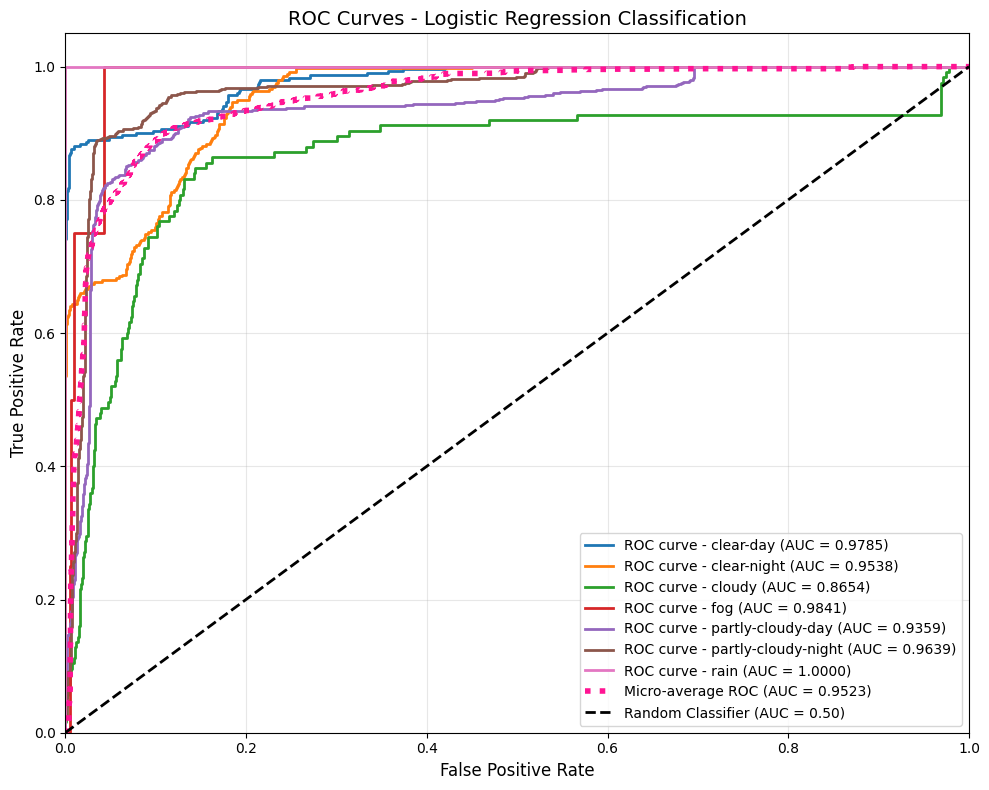

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9597
One-vs-One (Weighted)  : 0.9520
Micro-average          : 0.9523


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.790968, Best Accuracy: 0.841943
   Current F1: 0.818027, Best F1: 0.861714
   Current AUC (micro-avg): 0.952281, Best AUC: 0.964055
   Current Features: 23, Best Features: 27


### Standard Scaler

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [203]:
X_train

array([[ 0.08873237, -1.51753864, -0.3888967 , ..., -0.14489532,
        -0.73058589,  0.85292311],
       [ 0.08873237,  1.07523376, -0.3888967 , ...,  0.50907697,
        -0.73058589, -0.4299225 ],
       [ 0.71351944,  1.21927667, -0.3888967 , ..., -0.0533392 ,
        -0.73058589, -0.25690934],
       ...,
       [ 0.40112591, -1.22945281, -0.3888967 , ...,  1.02116571,
        -0.73058589, -0.4299225 ],
       [ 0.08873237, -0.07710953, -0.3888967 , ...,  0.95690582,
         2.19882202,  0.86767617],
       [ 0.40112591, -0.36519535, -0.3888967 , ...,  1.29498106,
         0.80247092, -0.4299225 ]], shape=(11692, 23))

In [204]:
X_test

array([[ 1.33830651, -1.51753864, -0.3888967 , ..., -1.4289557 ,
        -0.73058589, -0.4299225 ],
       [-0.22366116, -1.22945281, -0.3888967 , ..., -0.12186412,
        -0.73058589, -0.49027592],
       [ 0.71351944,  0.49906212,  2.5713769 , ...,  0.88667489,
         0.86431397,  0.7382516 ],
       ...,
       [ 0.71351944, -1.22945281, -0.3888967 , ...,  0.10105513,
        -0.73058589, -0.4299225 ],
       [ 1.65070004,  0.35501921,  2.5713769 , ..., -0.69536939,
         1.54784248, -0.4299225 ],
       [ 0.71351944, -0.07710953, -0.3888967 , ...,  1.32256164,
        -0.34325307, -0.4299225 ]], shape=(2923, 23))

#### Default Parameters

In [205]:
training_model = GaussianNB()
training_model

GaussianNB()

In [206]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 13.3 ms


GaussianNB()

In [207]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [208]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8283
Precision: 0.9099
Recall:    0.8283
F1-Score:  0.8561


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.85      0.90       301
        clear-night       0.95      0.62      0.75       362
             cloudy       0.40      0.02      0.03       125
                fog       0.01      1.00      0.02         4
  partly-cloudy-day       0.89      0.87      0.88       774
partly-cloudy-night       0.92      0.87      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.83      2923
          macro avg       0.73      0.75      0.64      2923
       weighted avg       0.91      0.83      0.86      2923



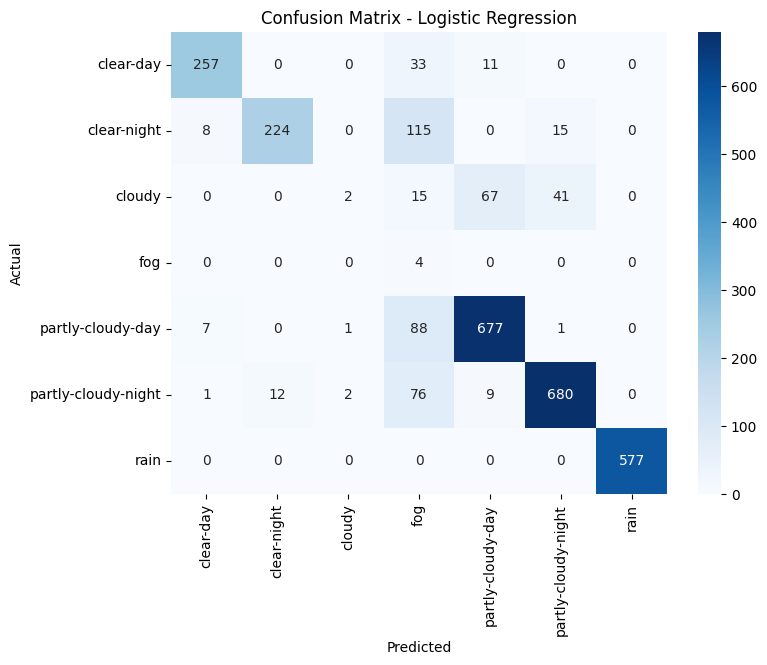

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9904
clear-night : 0.9786
cloudy   : 0.9402
fog      : 0.9611
partly-cloudy-day : 0.9644
partly-cloudy-night : 0.9744
rain     : 1.0000
Micro-avg : 0.9713


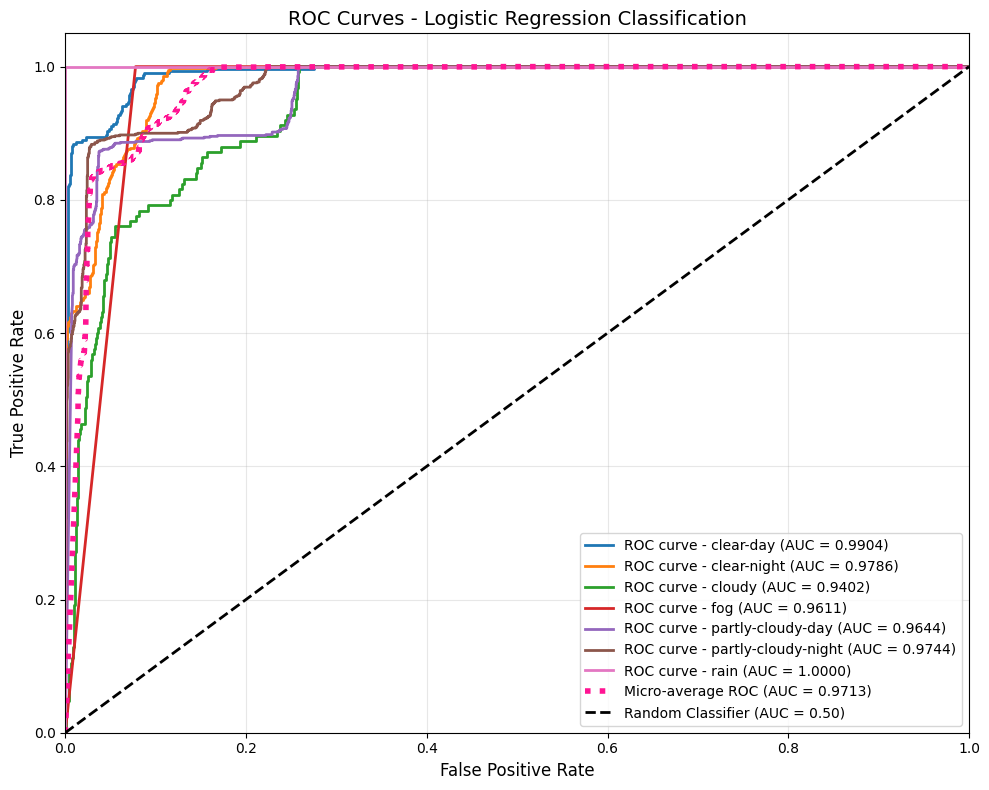

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9775
One-vs-One (Weighted)  : 0.9715
Micro-average          : 0.9713


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.829285 ≈ 0.828259 (similar)
   F1-Score: 0.855521 ≈ 0.856090 (similar)
   AUC (micro-avg): 0.971706 ≈ 0.971299
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 109 ms
Wall time: 844 ms


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 0.001}
Best Cross-Validation Score: 0.8905109902227084


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8758
Precision: 0.9236
Recall:    0.8758
F1-Score:  0.8844


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.95      0.90      0.92       301
        clear-night       0.99      0.78      0.87       362
             cloudy       0.71      0.04      0.08       125
                fog       0.02      1.00      0.04         4
  partly-cloudy-day       0.89      0.92      0.90       774
partly-cloudy-night       0.90      0.91      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.88      2923
          macro avg       0.78      0.79      0.67      2923
       weighted avg       0.92      0.88      0.88      2923



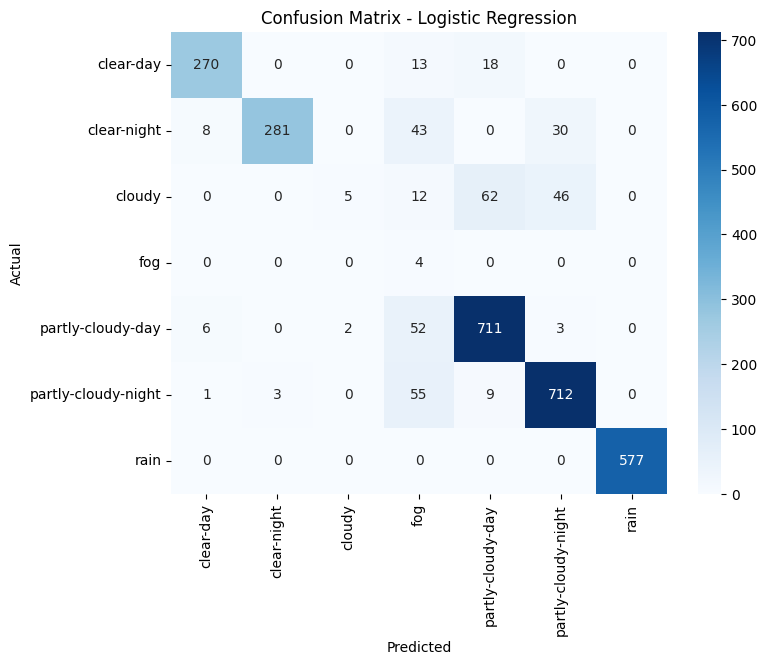

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9967
clear-night : 0.9962
cloudy   : 0.9470
fog      : 0.9937
partly-cloudy-day : 0.9802
partly-cloudy-night : 0.9815
rain     : 1.0000
Micro-avg : 0.9875


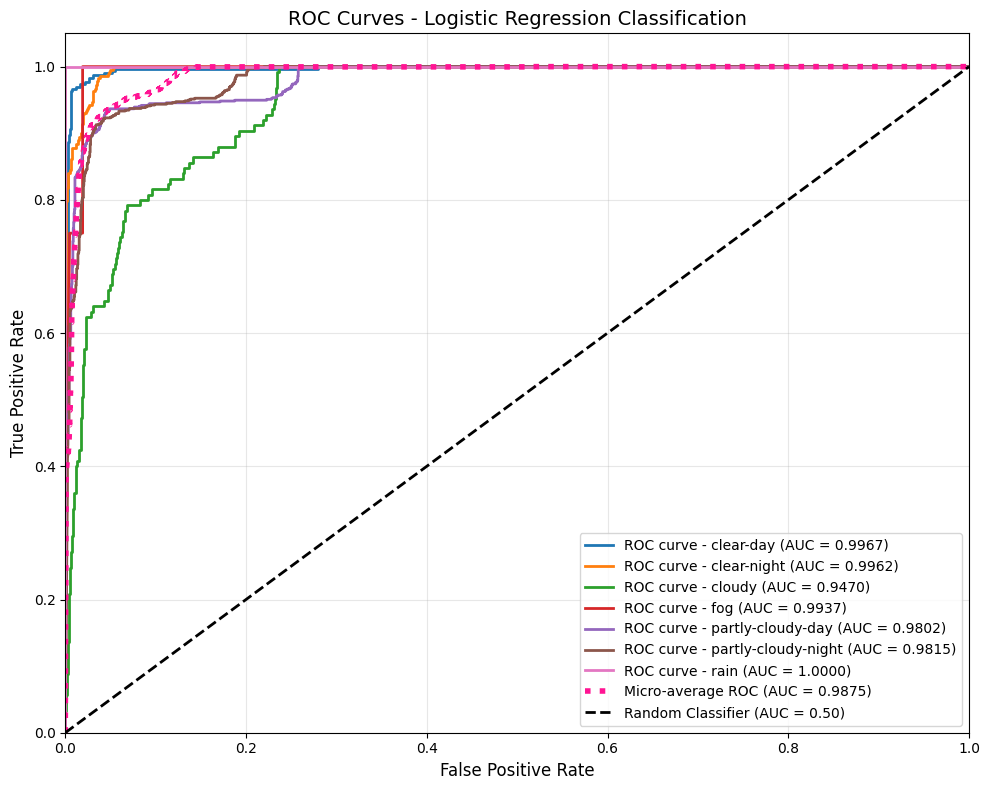

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9867
One-vs-One (Weighted)  : 0.9833
Micro-average          : 0.9875


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.878549 ≈ 0.875813 (similar)
   F1-Score: 0.886718 ≈ 0.884439 (similar)
   AUC (micro-avg): 0.987713 ≈ 0.987454
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = GaussianNB()
base_model

GaussianNB()

In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 281 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7841
Precision: 0.8611
Recall:    0.7841
F1-Score:  0.8120


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.77      0.89      0.82       301
        clear-night       0.74      0.63      0.68       362
             cloudy       0.33      0.01      0.02       125
                fog       0.01      1.00      0.02         4
  partly-cloudy-day       0.89      0.79      0.83       774
partly-cloudy-night       0.92      0.77      0.84       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.78      2923
          macro avg       0.66      0.73      0.60      2923
       weighted avg       0.86      0.78      0.81      2923



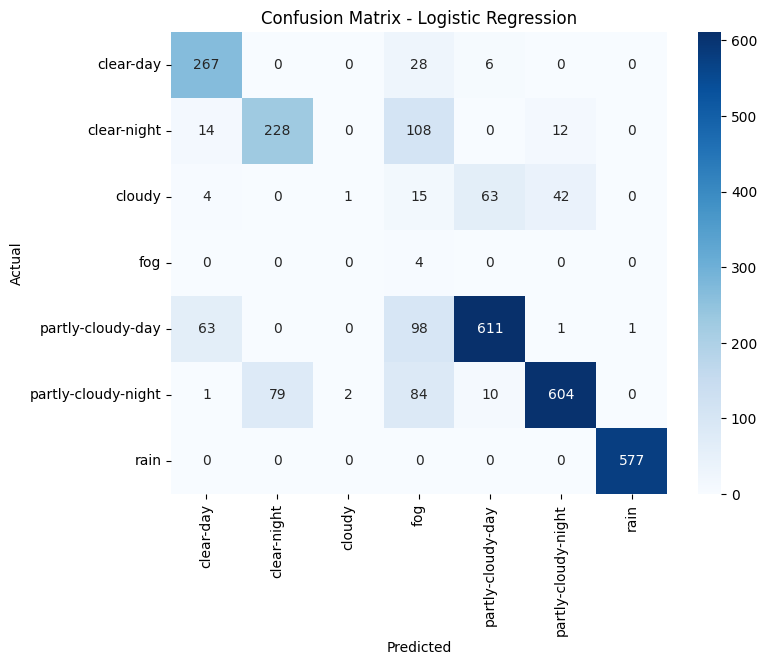

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9772
clear-night : 0.9506
cloudy   : 0.8647
fog      : 0.9838
partly-cloudy-day : 0.9346
partly-cloudy-night : 0.9622
rain     : 1.0000
Micro-avg : 0.9506


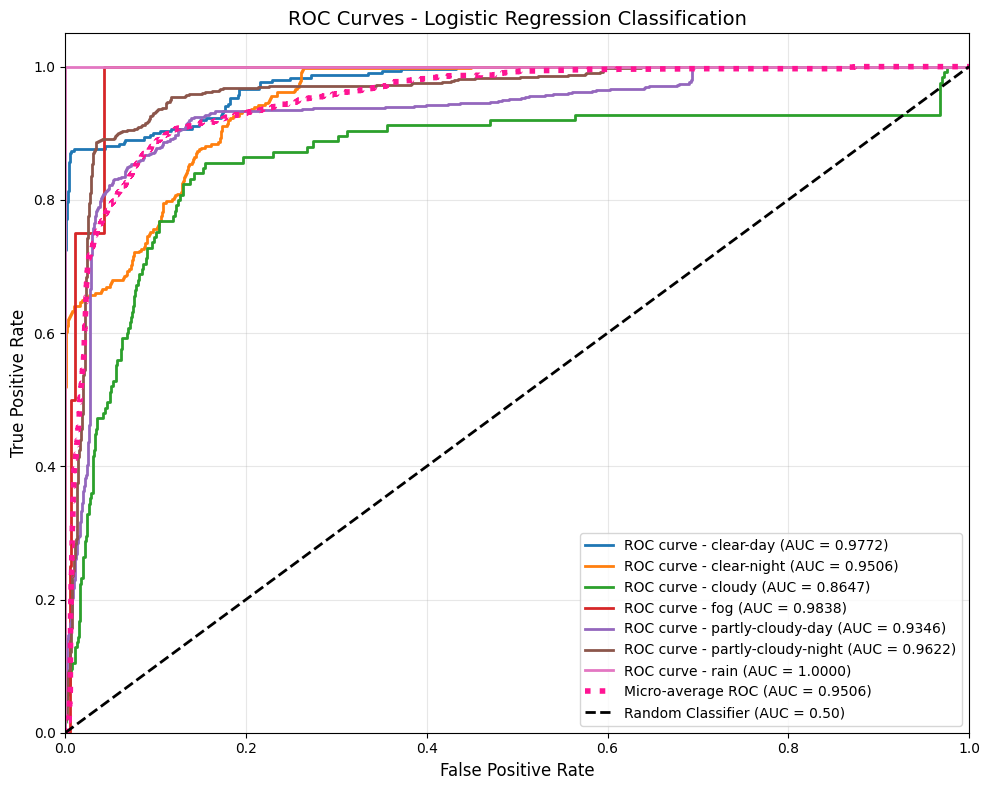

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9583
One-vs-One (Weighted)  : 0.9509
Micro-average          : 0.9506


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.784126, Best Accuracy: 0.835443
   Current F1: 0.811981, Best F1: 0.857263
   Current AUC (micro-avg): 0.950573, Best AUC: 0.962604
   Current Features: 23, Best Features: 27


### Robust Scaler

In [247]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [248]:
X_train

array([[ 0.00000000e+00, -9.16666667e-01,  0.00000000e+00, ...,
        -5.05562827e-02,  0.00000000e+00,  9.07710558e+00],
       [ 0.00000000e+00,  5.83333333e-01,  0.00000000e+00, ...,
         3.25752618e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         2.12696335e-03,  0.00000000e+00,  1.22419929e+00],
       ...,
       [ 2.00000000e-01, -7.50000000e-01,  0.00000000e+00, ...,
         6.20418848e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33333333e-02,  0.00000000e+00, ...,
         5.83442408e-01,  1.94805195e+00,  9.18149466e+00],
       [ 2.00000000e-01, -2.50000000e-01,  0.00000000e+00, ...,
         7.77977749e-01,  1.01948052e+00,  0.00000000e+00]],
      shape=(11692, 23))

In [249]:
X_test

array([[ 0.8       , -0.91666667,  0.        , ..., -0.78943063,
         0.        ,  0.        ],
       [-0.2       , -0.75      ,  0.        , ..., -0.03730366,
         0.        , -0.42704626],
       [ 0.4       ,  0.25      ,  1.        , ...,  0.5430301 ,
         1.06060606,  8.26571767],
       ...,
       [ 0.4       , -0.75      ,  0.        , ...,  0.09096859,
         0.        ,  0.        ],
       [ 1.        ,  0.16666667,  1.        , ..., -0.36731021,
         1.51515152,  0.        ],
       [ 0.4       , -0.08333333,  0.        , ...,  0.79384817,
         0.25757576,  0.        ]], shape=(2923, 23))

#### Default Parameters

In [250]:
training_model = GaussianNB()
training_model

GaussianNB()

In [251]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 17.1 ms


GaussianNB()

In [252]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype='<U19')

In [253]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8553
Precision: 0.9180
Recall:    0.8553
F1-Score:  0.8751


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.89      0.92       301
        clear-night       0.98      0.70      0.82       362
             cloudy       0.50      0.05      0.09       125
                fog       0.02      1.00      0.03         4
  partly-cloudy-day       0.89      0.89      0.89       774
partly-cloudy-night       0.92      0.90      0.91       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.86      2923
          macro avg       0.75      0.78      0.66      2923
       weighted avg       0.92      0.86      0.88      2923



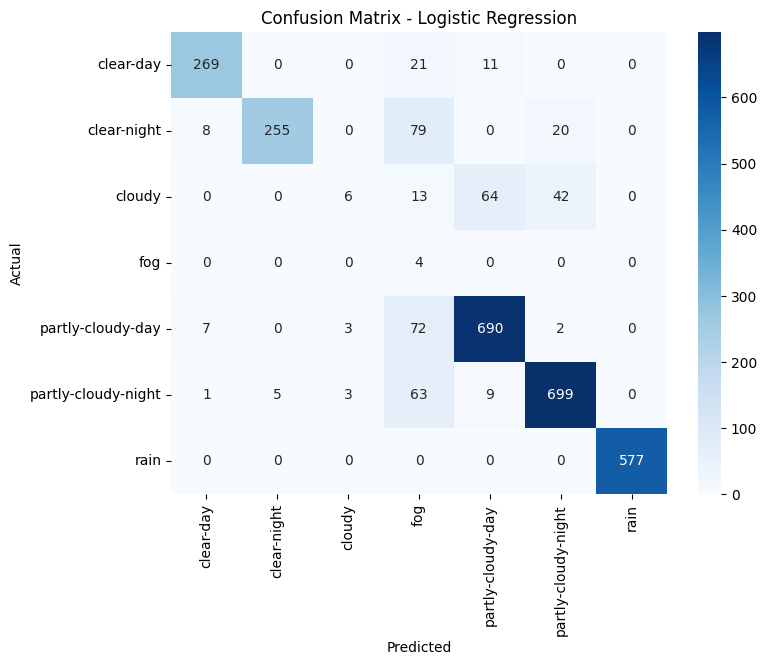

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9938
clear-night : 0.9914
cloudy   : 0.9448
fog      : 0.9846
partly-cloudy-day : 0.9726
partly-cloudy-night : 0.9769
rain     : 1.0000
Micro-avg : 0.9800


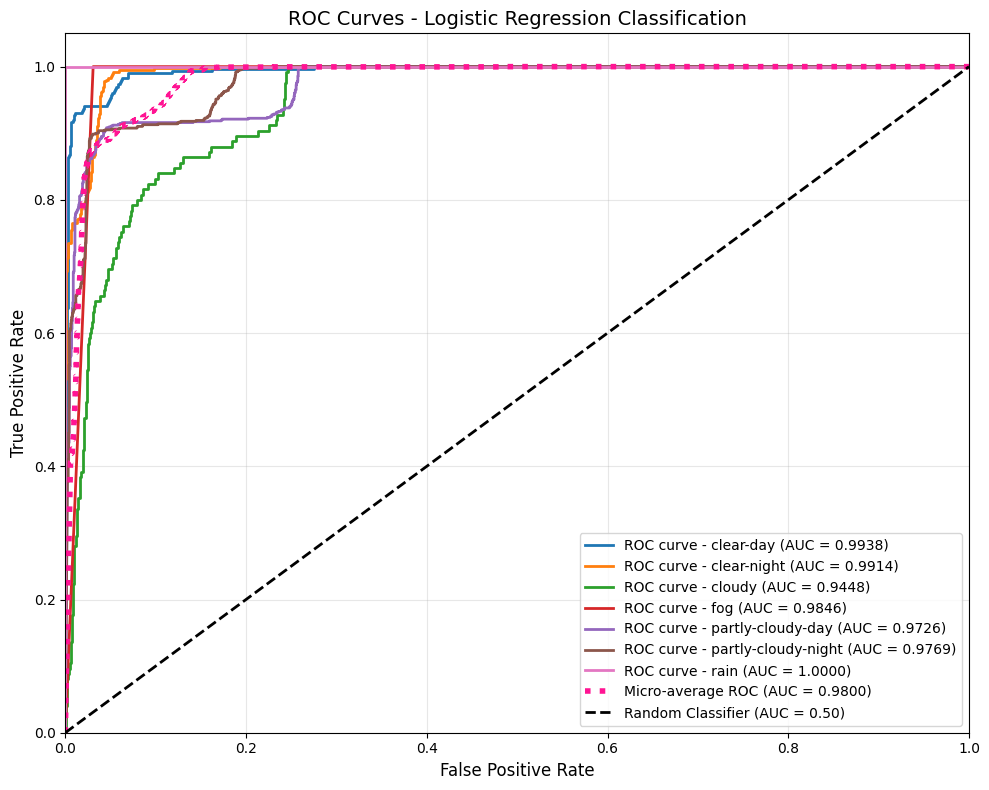

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9825
One-vs-One (Weighted)  : 0.9786
Micro-average          : 0.9800


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.856312 ≈ 0.855286 (similar)
   F1-Score: 0.875317 ≈ 0.875107 (similar)
   AUC (micro-avg): 0.980596 ≈ 0.979956
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [264]:
grid_search = RandomizedSearchCV(
    GaussianNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 109 ms
Wall time: 832 ms


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                          1e-06, 1e-05, 0.0001,
                                                          0.001, 0.01, 0.1]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [266]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'var_smoothing': 1e-07}
Best Cross-Validation Score: 0.8901389816396555


In [267]:
y_pred_grid = best_grid_model.predict(X_test)

In [268]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [269]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8717
Precision: 0.9151
Recall:    0.8717
F1-Score:  0.8875


In [270]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.94      0.91      0.93       301
        clear-night       0.98      0.80      0.88       362
             cloudy       0.42      0.10      0.17       125
                fog       0.02      1.00      0.04         4
  partly-cloudy-day       0.90      0.90      0.90       774
partly-cloudy-night       0.91      0.89      0.90       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.87      2923
          macro avg       0.74      0.80      0.69      2923
       weighted avg       0.92      0.87      0.89      2923



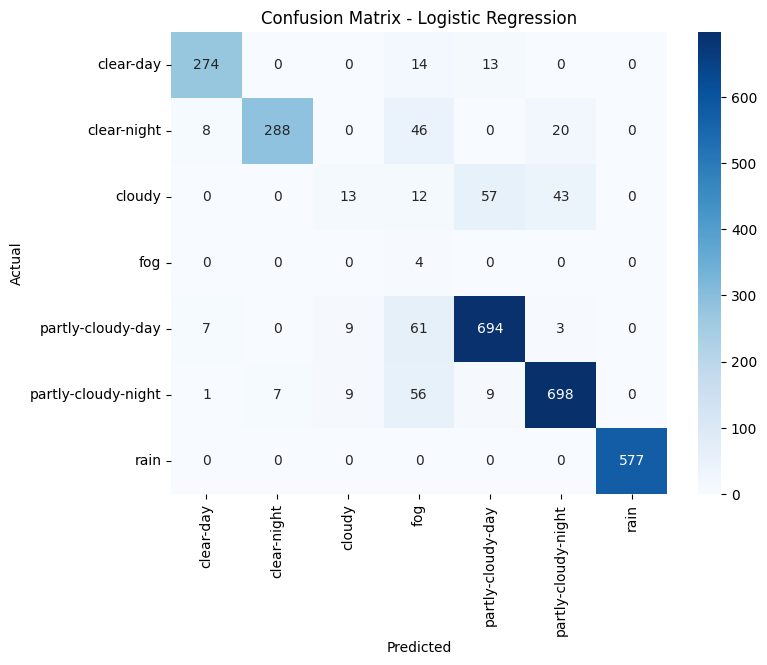

In [271]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [272]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [273]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [274]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9952
clear-night : 0.9940
cloudy   : 0.9414
fog      : 0.9919
partly-cloudy-day : 0.9776
partly-cloudy-night : 0.9802
rain     : 1.0000
Micro-avg : 0.9859


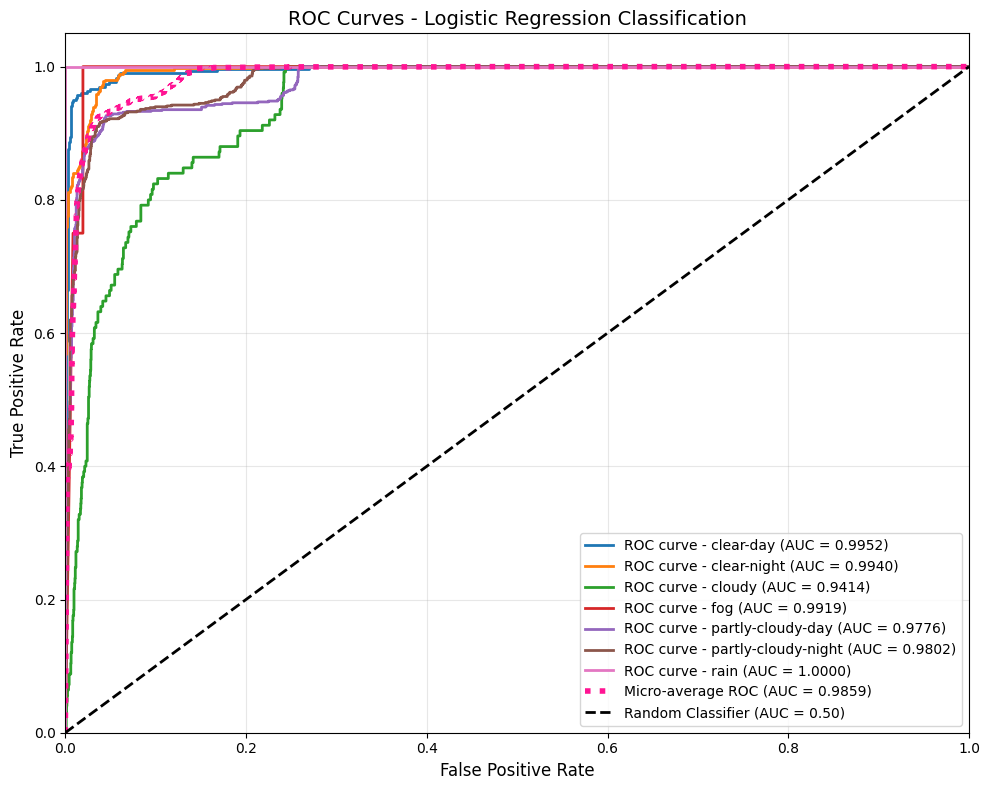

In [275]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [276]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9851
One-vs-One (Weighted)  : 0.9815
Micro-average          : 0.9859


In [277]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.872391 ≈ 0.871707 (similar)
   F1-Score: 0.887907 ≈ 0.887495 (similar)
   AUC (micro-avg): 0.986155 ≈ 0.985870
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [278]:
base_model = GaussianNB()
base_model

GaussianNB()

In [279]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 447 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


BaggingClassifier(bootstrap_features=True, estimator=GaussianNB(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [281]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [282]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [283]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8053
Precision: 0.8754
Recall:    0.8053
F1-Score:  0.8283


In [284]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.78      0.91      0.84       301
        clear-night       0.76      0.69      0.73       362
             cloudy       0.55      0.05      0.09       125
                fog       0.01      1.00      0.03         4
  partly-cloudy-day       0.89      0.80      0.85       774
partly-cloudy-night       0.91      0.79      0.85       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.81      2923
          macro avg       0.70      0.75      0.63      2923
       weighted avg       0.88      0.81      0.83      2923



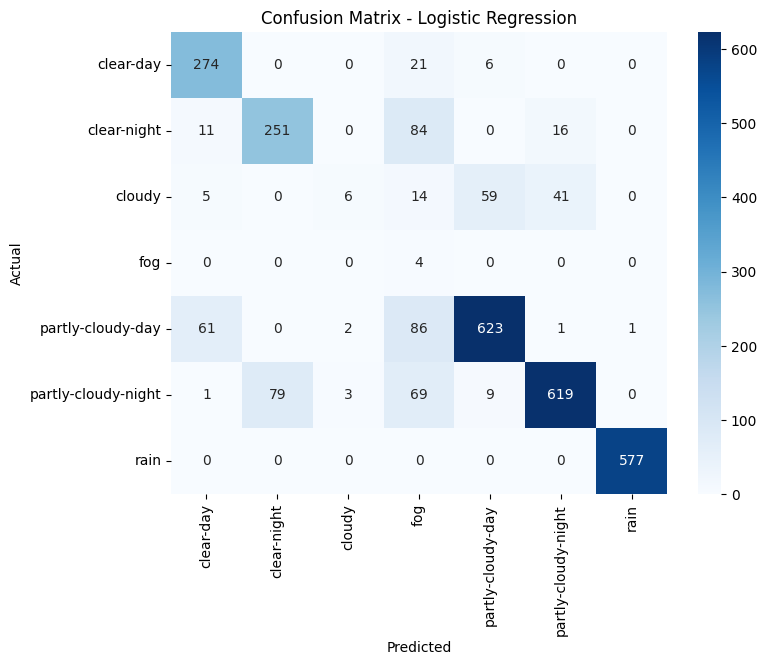

In [285]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [286]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [287]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [288]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9814
clear-night : 0.9630
cloudy   : 0.8816
fog      : 0.9853
partly-cloudy-day : 0.9429
partly-cloudy-night : 0.9632
rain     : 1.0000
Micro-avg : 0.9596


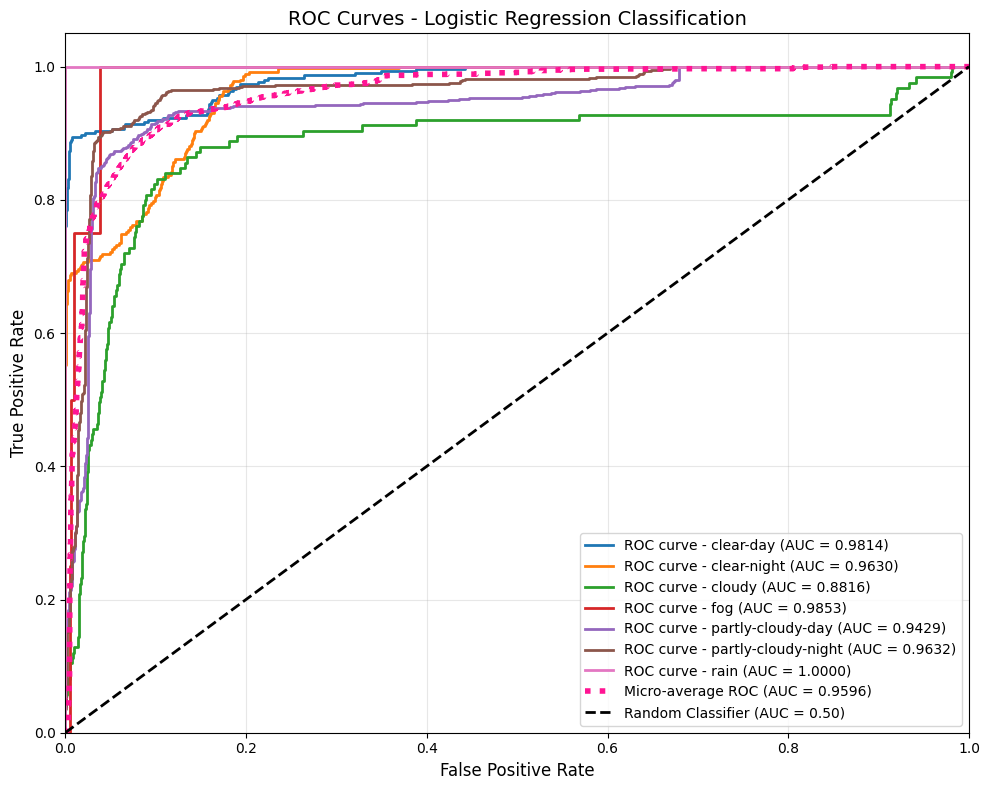

In [289]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [290]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9635
One-vs-One (Weighted)  : 0.9569
Micro-average          : 0.9596


In [291]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.805337, Best Accuracy: 0.867602
   Current F1: 0.828334, Best F1: 0.882888
   Current AUC (micro-avg): 0.959578, Best AUC: 0.970771
   Current Features: 23, Best Features: 27


# All Performance

In [292]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
                         Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
   Naive Bayes GaussianNB Grid   RobustScaler   Icon        23 0.871707  0.915094 0.871707 0.887495
   Naive Bayes GaussianNB Grid StandardScaler   Icon        23 0.875813  0.923606 0.875813 0.884439
   Naive Bayes GaussianNB Grid   MinMaxScaler   Icon        23 0.875128  0.923509 0.875128 0.884071
Naive Bayes GaussianNB Bagging   RobustScaler   Icon        27 0.867602  0.926741 0.867602 0.882888
        Naive Bayes GaussianNB   RobustScaler   Icon        23 0.855286  0.917988 0.855286 0.875107
Naive Bayes GaussianNB Bagging   MinMaxScaler   Icon        27 0.841943  0.911182 0.841943 0.861714
        Naive Bayes GaussianNB   MinMaxScaler   Icon        23 0.831680  0.914698 0.831680 0.858892
Naive Bayes GaussianNB Bagging StandardScaler   Icon        27 0.835443  0.910153 0.835443 0.857263
        Naive Bayes GaussianNB StandardScaler   Icon    

# <center><font size="50" color="red">Thank You</font></center>